<a href="https://colab.research.google.com/github/MathBioCU/WSINDy4Weather/blob/main/combined_forecast_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMBINED FORECAST ERROR PLOTS**

In [1]:
import torch
import scipy
import numpy as np
import matplotlib

import torch.linalg as la
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/WSINDy

file_path = '/content/drive/My Drive/WSINDy'

Mounted at /content/drive
/content/drive/My Drive/WSINDy


In [3]:
# Plot settings
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

matplotlib.rc('xtick', labelsize=9, direction='out')
matplotlib.rc('ytick', labelsize=9, direction='out')

## Get Spherical Data

In [4]:
# Import data
H_true = np.loadtxt(file_path+'/Dedalus/ground_truth_h.csv', delimiter=',')
H_pred = np.loadtxt(file_path+'/Dedalus/prediction_h.csv', delimiter=',')
W_true = np.loadtxt(file_path+'/Dedalus/ground_truth_vo.csv', delimiter=',')
W_pred = np.loadtxt(file_path+'/Dedalus/prediction_vo.csv', delimiter=',')
U = np.loadtxt(file_path+'/Dedalus/u.csv', delimiter=',')

H_true = torch.tensor(H_true)
H_pred = torch.tensor(H_pred)
W_true = torch.tensor(W_true)
W_pred = torch.tensor(W_pred)
U = torch.tensor(U)

# Reshape
(Nx, Ny) = (256, 128)
H_true = H_true.view(Nx, Ny, -1)
H_pred = H_pred.view(Nx, Ny, -1)
W_true = W_true.view(Nx, Ny, -1)
W_pred = W_pred.view(Nx, Ny, -1)
U = U.view(Nx, Ny, -1)

print(H_true.shape, H_pred.shape)

torch.Size([256, 128, 180]) torch.Size([256, 128, 180])


Velocity fluctuation: $u'_{ij}(t) := u_{ij}(t) - \bar{u}_{ij}$
\
Integral time-scale: \begin{align*}
T_0 := \mathbb{E}_{ij}\left[\sigma_{ij}^{-2}\int_0^{\infty} \mathbb{E}_t\left[ u'_{ij}(t) \, u'_{ij}(t - \tau) \right] \, d\tau\right]
\end{align*}

In [5]:
# Compute integral time scale
dt = 1
fluctuation = U - U.mean(dim=-1, keepdim=True)

# Sample some query points u[i,j](t)
samples = []
for i in range(0,U.shape[0],2):
  for j in range(0,U.shape[1],2):
    u_ij = fluctuation[i,j,:].clone()
    autocorr = scipy.signal.convolve(u_ij, u_ij.flip(0), mode='same')
    rho_ij = autocorr / (u_ij**2).sum().item()
    Tij = np.trapezoid(rho_ij, dx=dt)
    samples.append(Tij.item())

# Take average Tij
T0_spherical = np.mean(samples)
print(f'Integral timescale = {T0_spherical:.3f}')

Integral timescale = 23.358


In [6]:
# # SPHERE PLOT
# import matplotlib
# #matplotlib.use('Agg') # high quality renderer, can only write to files
# from mpl_toolkits.mplot3d import Axes3D

# [T, Nt, dt] = [180, 180, 1]
# t = torch.linspace(dt, T, Nt)
# x = np.linspace(0, 6.25864161, 256)
# y = np.linspace(0.01871455, 3.12287811, 128)

# thyme = -1
# tau = 0

# def build_s2_coord_vertices(phi, theta):
#   phi = phi.ravel()
#   phi_vert = np.concatenate([phi, [2*np.pi]])
#   phi_vert -= phi_vert[1] / 2
#   theta = theta.ravel()
#   theta_mid = (theta[:-1] + theta[1:]) / 2
#   theta_vert = np.concatenate([[np.pi], theta_mid, [0]])
#   return np.meshgrid(phi_vert, theta_vert, indexing='ij')

# # Sphere plot?
# sphere_plot = True

# if sphere_plot:
#   # Parameterized surface
#   phi_vert, theta_vert = build_s2_coord_vertices(x, y)
#   X = np.sin(theta_vert) * np.cos(phi_vert)
#   Y = np.sin(theta_vert) * np.sin(phi_vert)
#   Z = np.cos(theta_vert)

#   # Create figure
#   fig, ax = plt.subplots(2, 3, figsize=(12, 9), subplot_kw={'projection': '3d'})
#   (ax1,ax2,ax3) = ax[0,:]
#   (ax4,ax5,ax6) = ax[1,:]
#   cmap = plt.cm.coolwarm
#   cmap_error = plt.cm.cividis

#   # Data
#   data1 = (np.flip(W_true.numpy(), axis=1))[:,:,thyme]
#   data2 = (np.flip(W_pred.numpy(), axis=1))[:,:,thyme]
#   data3 = (np.flip(abs(W_true-W_pred).numpy(), axis=1))[:,:,thyme]

#   data4 = (np.flip(H_true.numpy(), axis=1))[:,:,thyme]
#   data5 = (np.flip(H_pred.numpy(), axis=1))[:,:,thyme]
#   data6 = (np.flip(abs(H_true-H_pred).numpy(), axis=1))[:,:,thyme]

#   clim1 = np.max(np.abs(data1))
#   clim2 = np.max(np.abs(data2))
#   clim3 = np.max(np.abs(data3))
#   clim6 = np.max(np.abs(data6))
#   norm1 = matplotlib.colors.Normalize(-clim1, clim1)
#   norm2 = matplotlib.colors.Normalize(-clim2, clim2)
#   norm3 = matplotlib.colors.Normalize(0, clim3)
#   norm4 = matplotlib.colors.Normalize(data4.min(), data4.max())
#   norm5 = matplotlib.colors.Normalize(data5.min(), data5.max())
#   norm6 = matplotlib.colors.Normalize(0, clim6)
#   fc1 = cmap(norm1(data1))
#   fc2 = cmap(norm2(data2))
#   fc3 = cmap_error(norm3(data3))
#   fc4 = cmap(norm4(data4))
#   fc5 = cmap(norm5(data5))
#   fc6 = cmap_error(norm6(data6))

#   # Plot scalar fields on sphere
#   surf1 = ax1.plot_surface(X, Y, Z, facecolors=fc1, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)
#   surf2 = ax2.plot_surface(X, Y, Z, facecolors=fc2, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)
#   surf3 = ax3.plot_surface(X, Y, Z, facecolors=fc3, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)
#   text1 = ax1.text(-2.5, 1.5, 0, f'Vorticity $(\zeta)$', color='black', fontsize=11, ha='left', va='top')

#   surf4 = ax4.plot_surface(X, Y, Z, facecolors=fc4, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)
#   text2 = ax4.text(-2.5, 1.5, 0, f'Height $(h)$', color='black', fontsize=11, ha='left', va='top')
#   surf5 = ax5.plot_surface(X, Y, Z, facecolors=fc5, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)
#   surf6 = ax6.plot_surface(X, Y, Z, facecolors=fc6, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)

#   # Add colorbars for each axis
#   mappable1 = plt.cm.ScalarMappable(norm=norm1, cmap=cmap)
#   mappable1.set_array(data1)
#   fig.colorbar(mappable1, ax=ax1, orientation='horizontal', shrink=0.8, location='bottom', pad=0.01)
#   mappable2 = plt.cm.ScalarMappable(norm=norm2, cmap=cmap)
#   mappable2.set_array(data2)
#   fig.colorbar(mappable2, ax=ax2, orientation='horizontal', shrink=0.8, location='bottom', pad=0.01)
#   mappable3 = plt.cm.ScalarMappable(norm=norm3, cmap=cmap_error)
#   mappable3.set_array(data3)
#   fig.colorbar(mappable3, ax=ax3, orientation='horizontal', shrink=0.8, location='bottom', pad=0.01, format='%.1e')

#   mappable4 = plt.cm.ScalarMappable(norm=norm4, cmap=cmap)
#   mappable4.set_array(data4)
#   fig.colorbar(mappable4, ax=ax4, orientation='horizontal', shrink=0.8, location='bottom', pad=0.01, format='%.1e')
#   mappable5 = plt.cm.ScalarMappable(norm=norm5, cmap=cmap)
#   mappable5.set_array(data5)
#   fig.colorbar(mappable5, ax=ax5, orientation='horizontal', shrink=0.8, location='bottom', pad=0.01, format='%.1e')
#   mappable6 = plt.cm.ScalarMappable(norm=norm6, cmap=cmap_error)
#   mappable6.set_array(data6)
#   fig.colorbar(mappable6, ax=ax6, orientation='horizontal', shrink=0.8, location='bottom', pad=0.01)

#   ax1.set_box_aspect((1,1,1))
#   ax1.set_xlim(-0.7, 0.7)
#   ax1.set_ylim(-0.7, 0.7)
#   ax1.set_zlim(-0.7, 0.7)
#   ax1.axis('off')
#   ax1.set_title(f'True $(\\tau + {t[thyme]-tau:.0f}\,'+'\\text{hr})$')

#   ax2.set_box_aspect((1,1,1))
#   ax2.set_xlim(-0.7, 0.7)
#   ax2.set_ylim(-0.7, 0.7)
#   ax2.set_zlim(-0.7, 0.7)
#   ax2.axis('off')
#   ax2.set_title(f'Predicted $(\\tau + {t[thyme]-tau:.0f}\,'+'\\text{hr})$')

#   ax3.set_box_aspect((1,1,1))
#   ax3.set_xlim(-0.7, 0.7)
#   ax3.set_ylim(-0.7, 0.7)
#   ax3.set_zlim(-0.7, 0.7)
#   ax3.axis('off')
#   ax3.set_title('Absolute Error')

#   ax4.set_box_aspect((1,1,1))
#   ax4.set_xlim(-0.7, 0.7)
#   ax4.set_ylim(-0.7, 0.7)
#   ax4.set_zlim(-0.7, 0.7)
#   ax4.axis('off')

#   ax5.set_box_aspect((1,1,1))
#   ax5.set_xlim(-0.7, 0.7)
#   ax5.set_ylim(-0.7, 0.7)
#   ax5.set_zlim(-0.7, 0.7)
#   ax5.axis('off')

#   ax6.set_box_aspect((1,1,1))
#   ax6.set_xlim(-0.7, 0.7)
#   ax6.set_ylim(-0.7, 0.7)
#   ax6.set_zlim(-0.7, 0.7)
#   ax6.axis('off')

#   plt.tight_layout()
#   plt.show()

In [7]:
error = H_true - H_pred
abs_error = abs(H_true - H_pred)

# Time series of average spatial error
Et = abs_error.mean(dim=(0,1))
Et_rel = Et/abs(H_true).mean(dim=(0,1))

# Time until tolerance
[T, Nt, dt] = [180, 180, 1]
tau = torch.linspace(dt, T, Nt)
try:
  t_tol_index = torch.where(Et_rel > 0.1, True, False).nonzero()[0]
  t_tol = tau[t_tol_index]
except:
  t_tol = None

# RMSE
rmse = (la.norm(error) / la.norm(H_true)).item()

# Explained variance
top = torch.dot((error).reshape(-1), (error).reshape(-1))
bot = torch.dot((H_true-H_true.mean()).reshape(-1),
                (H_true-H_true.mean()).reshape(-1))
R2 = 1 - (top/bot).item()

# Print some results
print(f'Relative RMSE = {rmse:.3e}')
print(f'R^2 = {R2:.3f}')
print(f't_tol = {t_tol}')
print(f'E_f = {Et_rel[-1].item():.3e}')

Relative RMSE = 1.067e-04
R^2 = 1.000
t_tol = None
E_f = 1.945e-04


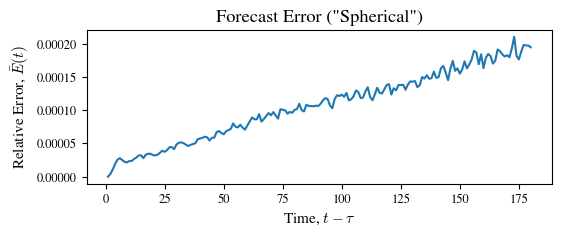

In [8]:
# Plot that time series
fig, ax = plt.subplots(1, figsize=(6,2))

ax.plot(tau, Et_rel)
#ax.axvline(x=t_tol, ymin=0, ymax=0.285, ls='--', color='k', lw=1)
#ax.axhline(y=Et_rel[t_tol_index], xmin=0, xmax=0.25, ls='--', color='k', lw=1)
#ax.plot(t_tol, Et_rel[t_tol_index], 'ro', label='$\\tau_{\\rm{tol}}$')
ax.set_xlabel('Time, $t-\\tau$')
ax.set_ylabel('Relative Error, $\\bar{E}(t)$')
ax.set_title(f'Forecast Error ("Spherical")')
#ax.legend()
plt.show()

In [9]:
Et_spherical = Et_rel
t_tol_spherical = t_tol

## Get Barotropic Data

In [10]:
# File path for ground truth data
data_path_true = file_path + '/PyQuasiGeostrophic/ground_truth.csv'

# File path for predicted data
data_path_pred = file_path + '/PyQuasiGeostrophic/prediction.csv'

# Read in CSV data
W_true = np.loadtxt(data_path_true, delimiter=',')
W_pred = np.loadtxt(data_path_pred, delimiter=',')
U = np.loadtxt(file_path + '/PyQuasiGeostrophic/geostrophic_U.csv', delimiter=',')

# Convert to torch tensor
W_true = torch.tensor(W_true)
W_pred = torch.tensor(W_pred)
U = torch.tensor(U)

# Reshape into a Nx x Ny x Nt tensor
[Lx, Ly, T] = [2*np.pi, 2*np.pi, 20]
[Nx, Ny, Nt] = [256, 256, 160]
dt = 0.1257861703634262
x = torch.linspace(0, Lx, Nx)
y = torch.linspace(0, Ly, Ny)
t = torch.linspace(dt, T//2, Nt//2)
X,Y = torch.meshgrid(x, y, indexing='ij')
W_true = W_true.view(Nx, Ny, -1)
W_pred = W_pred.view(Nx, Ny, -1)
U = U.view(Nx, Ny, -1)

# Transpose the data
W_true = W_true.transpose(0,1)
W_pred = W_pred.transpose(0,1)
U = U.transpose(0,1)

print(f"Imported tensor with shape {W_true.shape, W_pred.shape}")

# Clear other variables
del Nx, Ny
del data_path_true, data_path_pred

Imported tensor with shape (torch.Size([256, 256, 80]), torch.Size([256, 256, 80]))


Velocity fluctuation: $u'_{ij}(t) := u_{ij}(t) - \bar{u}_{ij}$
\
Integral time-scale: \begin{align*}
T_0 := \mathbb{E}_{ij}\left[\sigma_{ij}^{-2}\int_0^{\infty} \mathbb{E}_t\left[ u'_{ij}(t) \, u'_{ij}(t - \tau) \right] \, d\tau\right]
\end{align*}

In [11]:
# Compute integral time scale
fluctuation = U - U.mean(dim=-1, keepdim=True)

# Sample some query points u[i,j](t)
samples = []
for i in range(0,U.shape[0],2):
  for j in range(0,U.shape[1],2):
    u_ij = fluctuation[i,j,:].clone()
    autocorr = scipy.signal.convolve(u_ij, u_ij.flip(0), mode='same')
    rho_ij = autocorr / (u_ij**2).sum().item()
    Tij = np.trapezoid(rho_ij, dx=dt)
    samples.append(Tij.item())

# Take average Tij
T0_barotropic = np.mean(samples)
print(f'Integral timescale = {T0_barotropic:.3f}')

Integral timescale = 1.794


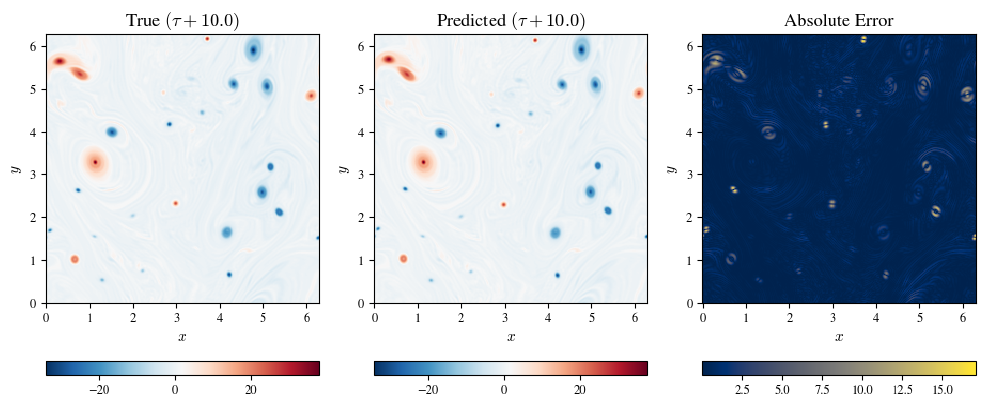

In [12]:
# Plot the data
thyme = -1
tau = 0
error = abs(W_true[:,:,thyme] - W_pred[:,:,thyme])

fig,ax = plt.subplots(1,3, figsize=(12,5))

im = ax[0].pcolormesh(X, Y, W_true[:,:,thyme].T, cmap='RdBu_r')
plt.colorbar(im, orientation='horizontal')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_title(f'True $(\\tau + {t[thyme]-tau:.1f})$')

im = ax[1].pcolormesh(X, Y, W_pred[:,:,thyme].T, cmap='RdBu_r')
plt.colorbar(im, orientation='horizontal')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
ax[1].set_title(f'Predicted $(\\tau + {t[thyme]-tau:.1f})$')

im = ax[2].pcolormesh(X, Y, error.T, cmap='cividis')
plt.colorbar(im, orientation='horizontal')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$y$')
ax[2].set_title(f'Absolute Error')
plt.show()

In [13]:
error = W_true - W_pred
abs_error = abs(W_true - W_pred)

# Time series of average spatial error
Et = abs_error.mean(dim=(0,1))
Et_rel = Et/abs(W_true).mean(dim=(0,1))

# Time until tolerance
[T, Nt, dt] = [10, 80, 0.125]
tau = np.linspace(dt, T, Nt)
t_tol_index = torch.where(Et_rel > 0.1, True, False).nonzero()[0]
t_tol = tau[t_tol_index]

# RMSE
rmse = (la.norm(error) / torch.norm(W_true)).item()

# Explained variance
top = torch.dot((error).reshape(-1), (error).reshape(-1))
bot = torch.dot((W_true-W_true.mean()).reshape(-1),
                (W_true-W_true.mean()).reshape(-1))
R2 = 1 - (top/bot).item()

# Print some results
print(f'Relative RMSE = {rmse:.3e}')
print(f'R^2 = {R2:.3e}')
print(f't_tol = {t_tol:.3f}')
print(f'E_f = {Et_rel[-1].item():.3e}')

Relative RMSE = 2.067e-01
R^2 = 9.573e-01
t_tol = 2.500
E_f = 3.454e-01


In [14]:
print(f't_tol/T0 = {t_tol/T0_barotropic}')

t_tol/T0 = 1.3932657907833785


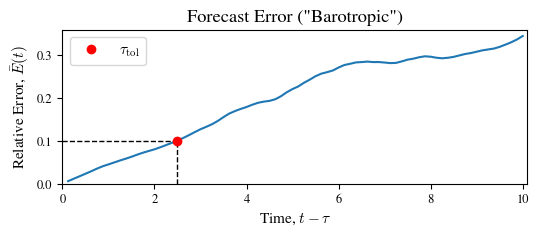

In [15]:
# Plot that time series
fig, ax = plt.subplots(1, figsize=(6,2))

ax.plot(tau, Et_rel)
ax.axvline(x=t_tol, ymin=0, ymax=0.285, ls='--', color='k', lw=1)
ax.axhline(y=Et_rel[t_tol_index], xmin=0, xmax=0.25, ls='--', color='k', lw=1)
ax.plot(t_tol, Et_rel[t_tol_index], 'ro', label='$\\tau_{\\rm{tol}}$')
ax.set_xlabel('Time, $t-\\tau$')
ax.set_ylabel('Relative Error, $\\bar{E}(t)$')
ax.set_title(f'Forecast Error ("Barotropic")')
ax.set_xlim([0, 10.1])
ax.set_ylim([0, 0.36])
ax.legend()
plt.show()

In [16]:
Et_barotropic = Et_rel
t_tol_barotropic = t_tol

## Get Stratified Data

In [17]:
# File path for ground truth data
data_path_true = file_path + '/JHTDB/geophysical/ground_truth.csv'

# File path for predicted data
data_path_pred = file_path + '/JHTDB/geophysical/prediction.csv'

# Read in CSV data
Temp_true = np.loadtxt(data_path_true, delimiter=',')
Temp_pred = np.loadtxt(data_path_pred, delimiter=',')
U = np.loadtxt(file_path + '/JHTDB/geophysical/u.csv', delimiter=',')

# Convert to torch tensor
Temp_true = torch.tensor(Temp_true)
Temp_pred = torch.tensor(Temp_pred)
U = torch.tensor(U)

# Reshape into a Nx x Ny x Nt tensor
[Lx, Ly, T] = [62, 62, 100*0.075]
[Nx, Ny, Nt] = [62, 62, 100]
[dx, dy, dt] = [1, 1, 0.075]
x = torch.arange(0, Nx, dx)
y = torch.arange(0, Ny, dy)
t = torch.arange(0, T, dt)
t = t[-33:]
X,Y = torch.meshgrid(x, y, indexing='ij')
Temp_true = Temp_true.view(Nx, Ny, -1).transpose(0,1)
Temp_pred = Temp_pred.view(Nx, Ny, -1).transpose(0,1)
U = U.view(Nx, Ny, -1).transpose(0,1)

print(f"Imported tensor with shape {Temp_true.shape, Temp_pred.shape}")

# Clear other variables
del Nx, Ny
del data_path_true, data_path_pred

Imported tensor with shape (torch.Size([62, 62, 33]), torch.Size([62, 62, 33]))


Velocity fluctuation: $u'_{ij}(t) := u_{ij}(t) - \bar{u}_{ij}$
\
Integral time-scale: \begin{align*}
T_0 := \mathbb{E}_{ij}\left[\sigma_{ij}^{-2}\int_0^{\infty} \mathbb{E}_t\left[ u'_{ij}(t) \, u'_{ij}(t - \tau) \right] \, d\tau\right]
\end{align*}

In [18]:
# Compute integral time scale
dt = 1
fluctuation = U - U.mean(dim=-1, keepdim=True)

# Sample some query points u[i,j](t)
samples = []
for i in range(0,U.shape[0],2):
  for j in range(0,U.shape[1],2):
    u_ij = fluctuation[i,j,:].clone()
    autocorr = scipy.signal.convolve(u_ij, u_ij.flip(0), mode='same')
    rho_ij = autocorr / (u_ij**2).sum().item()
    Tij = np.trapezoid(rho_ij, dx=dt)
    samples.append(Tij.item())

# Take average Tij
T0_stratified = np.mean(samples)
print(f'Integral timescale = {T0_stratified:.3f}')

Integral timescale = 6.267


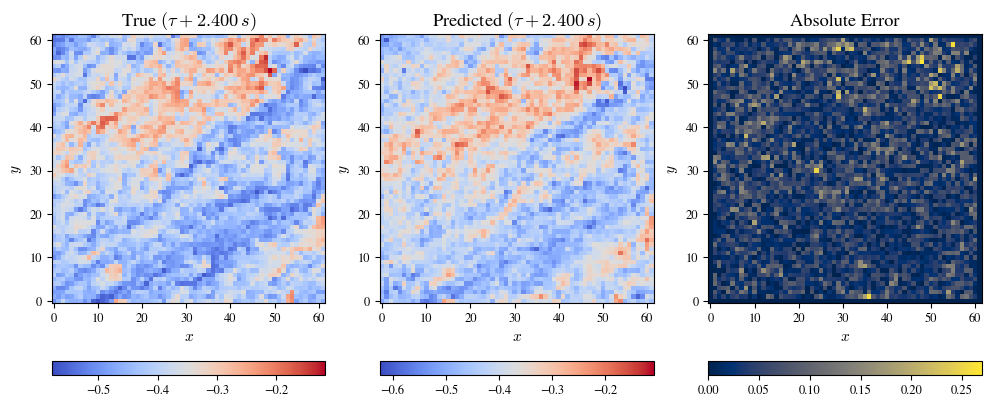

In [19]:
# Compare to true solution
thyme = -1
tau = t[0]
error = abs(Temp_true[:,:,thyme] - Temp_pred[:,:,thyme])

fig,ax = plt.subplots(1,3, figsize=(12,5))

im = ax[0].pcolormesh(X, Y, Temp_true[:,:,thyme].T, cmap='coolwarm')
plt.colorbar(im, orientation='horizontal')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_title(f'True $(\\tau + {t[thyme]-tau:.3f} \, s)$')

im = ax[1].pcolormesh(X, Y, Temp_pred[:,:,thyme].T, cmap='coolwarm')
plt.colorbar(im, orientation='horizontal')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
ax[1].set_title(f'Predicted $(\\tau + {t[thyme]-tau:.3f} \, s)$')

im = ax[2].pcolormesh(X, Y, error.T, cmap='cividis')
plt.colorbar(im, orientation='horizontal')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$y$')
ax[2].set_title(f'Absolute Error')
plt.show()

In [20]:
error = Temp_true - Temp_pred
abs_error = abs(error)

# Time series of average spatial error
Et = abs_error.mean(dim=(0,1))
Et_rel = Et / abs(Temp_true).mean(dim=(0,1))

# Time until tolerance
tau = t - t[0]
t_tol_index = torch.where(Et_rel > 0.1, True, False).nonzero()[0]
t_tol = tau[t_tol_index].item()

# Percentage RMSE
rmse = (la.norm(error)/la.norm(Temp_true)).item()

# Explained variance
top = torch.dot((error).reshape(-1), (error).reshape(-1))
bot = torch.dot((Temp_true-Temp_true.mean()).reshape(-1),
                (Temp_true-Temp_true.mean()).reshape(-1))
var_exp = 1 - (top/bot).item()

# Print some results
print(f'Relative RMSE = {rmse:.3f}')
print(f'Explained var = {var_exp:.3f}')
print(f't_tol = {t_tol:.3f}')
print(f'E_f = {Et_rel[-1].item():.3f}')

Relative RMSE = 0.136
Explained var = 0.465
t_tol = 0.525
E_f = 0.121


In [21]:
print(f't_tol/T0 = {t_tol/T0_spherical}')

t_tol/T0 = 0.022476407925778902


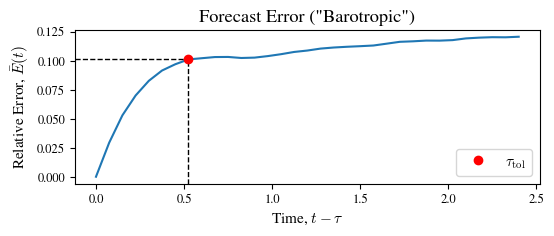

In [22]:
# Plot that time series
fig, ax = plt.subplots(1, figsize=(6,2))

ax.plot(tau, Et_rel)
ax.axvline(x=t_tol, ymin=0, ymax=0.8, ls='--', color='k', lw=1)
ax.axhline(y=Et_rel[t_tol_index], xmin=0, xmax=0.25, ls='--', color='k', lw=1)
ax.plot(t_tol, Et_rel[t_tol_index], 'ro', label='$\\tau_{\\rm{tol}}$')
ax.set_xlabel('Time, $t-\\tau$')
ax.set_ylabel('Relative Error, $\\bar{E}(t)$')
ax.set_title(f'Forecast Error ("Barotropic")')
ax.legend()
plt.show()

In [23]:
Et_stratified = Et_rel
t_tol_stratified = t_tol

## Compare Error Against Integration Time

In [24]:
errors = [Et_spherical, Et_barotropic, Et_stratified]
tols = [t_tol_spherical, t_tol_barotropic, t_tol_stratified]
T0s = [T0_spherical, T0_barotropic, T0_stratified]

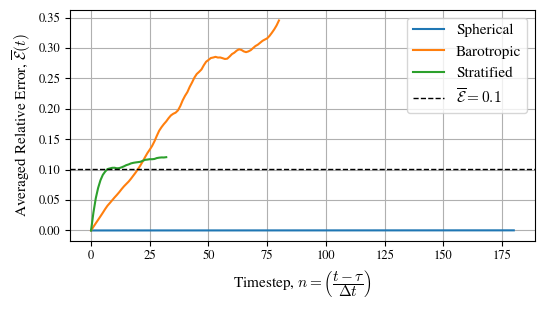

In [25]:
plt.figure(figsize=(6,3))

plt.plot([0]+Et_spherical.tolist(), label='Spherical')
plt.plot([0]+Et_barotropic.tolist(), label='Barotropic')
plt.plot(Et_stratified, label='Stratified')
plt.axhline(y=Et_rel[t_tol_index], xmin=0, xmax=1,
            ls='--', color='k', lw=1, label='$\overline{\mathcal{E}} = 0.1$')
#plt.ylim([1e-6, 1e0])
#plt.yscale('log')
plt.xlabel(r'Timestep, $n = \left(\dfrac{t - \tau}{\Delta t}\right)$')
plt.ylabel(r'Averaged Relative Error, $\overline{\mathcal{E}}(t)$')
#plt.title('Forecasting Errors')
plt.grid(True)
plt.legend()
plt.show()

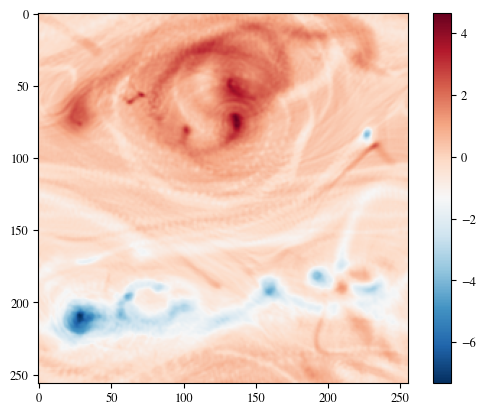

In [26]:
plt.imshow((W_true.mean(dim=-1, keepdim=True))[:,:,-1].T,cmap='RdBu_r')
plt.colorbar()

In [27]:
# Spherical
tau_spherical = torch.linspace(1, 180, 180)
tau_spherical = [0] + (tau_spherical/T0s[0]).tolist()

# Barotropic
tau_barotropic = torch.linspace(0.125, 10, 80)
tau_barotropic = [0] + (tau_barotropic/T0s[1]).tolist()

# Stratified
tau_stratified = (torch.arange(0, 100*0.075, 0.075)[-33:] - 5.025)/T0s[2]

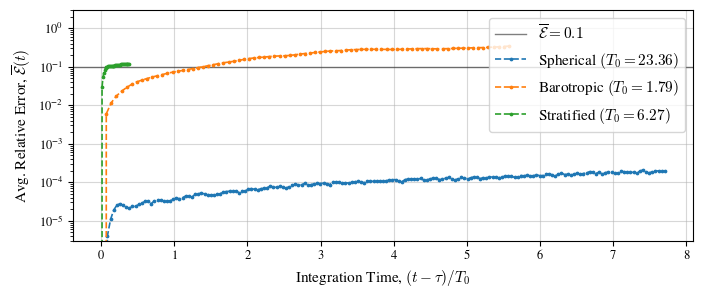

In [28]:
plt.figure(figsize=(8,3))

plt.axhline(y=Et_rel[t_tol_index], xmin=0, xmax=1, alpha=0.5,
            ls='-', color='k', lw=1, label='$\overline{\mathcal{E}} = 0.1$')
plt.plot(tau_spherical, [0]+Et_spherical.tolist(), 'o--', ms=1.7, lw=1.2, label=f'Spherical $(T_0 = {T0s[0]:.2f})$')
plt.plot(tau_barotropic, [0]+Et_barotropic.tolist(), 'o--', ms=1.7, lw=1.2, label=f'Barotropic $(T_0 = {T0s[1]:.2f})$')
plt.plot(tau_stratified, Et_stratified, 'o--', ms=1.7, lw=1.2, label=f'Stratified $(T_0 = {T0s[2]:.2f})$')
#plt.xlim([3e-7, 1e3])
plt.ylim([3e-6, 0.3e1])
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Integration Time, $(t - \tau)/T_0$')
plt.ylabel(r'Avg. Relative Error, $\overline{\mathcal{E}}(t)$')
#plt.title('Forecasting Errors')
plt.grid(True, alpha=0.5)
plt.legend(loc='upper right')
plt.show()